## Rockhound Convolutional Neural Network
Author: Giovan Cervantes

#### __Description:__
The purpose of this cnn is to accurately identify minerals in photographs. This task boils down to classification, which is why I'm using a cnn as apposed to other types of neural networks. As the name suggests Cnn's have a convolutional layer which help pick up on spatial features, something a standard Neural Network can't do.

#### __Dataset Details__
The data consists of labeled images of rocks and minerals organized by their respective types.

There are two sets of data, the [__training data__](#training-data-processing) and the [__testing data__](#test-data-processing). Each set follows the same structure outlined above, with the only difference coming from how the images are preprocessed. <br><br>

#### __Challenges:__
Since the input data consists of images of rocks, the first challenge was collecting enough data to effectively train the model. This involved carefully selecting appropriate images for each class and deciding how in depth the class structure should be.

This ties directly into the second challenge: achieving decent model accuracy. Convolutional neural networks (CNNs) require a substantial amount of data to train effectively, and the nature of the classification target — rocks — adds complexity. Rocks within the same class can vary significantly in color, texture, and shape, making it difficult for the model to generalize and accurately differentiate between them.
<br><br>

***

#### Step 1: Load Dataset
Here I'm looping through the dataset folder, creating a list of image paths and corresponding labels.

In [1]:
import os
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [2]:
#Path to the dataset
dataset_path = './dataset/'

# Defining 2 arrays to eventually store image paths and labels
image_paths = []
image_labels = []

# Const variable for image size
IMAGE_SIZE = 256

# Collect image paths and labels
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    # Check if folder_path is a directory
    if os.path.isdir(folder_path):
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            subfolder_path = os.path.normpath(subfolder_path).replace('\\', '/')

            # Store the path and label (class name)
            class_name = folder
            image_paths.append(subfolder_path)
            image_labels.append(class_name)


#### Step 2: Splitting dataset
The second step is to split the data into a set for training and a set for testing. This can be done manually, but instead I'm going to utilize scikit-learn's `train_test_split()` method with an 80/20 split (80% used for training and 20% for testing).

In [3]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, 
    image_labels, 
    test_size=0.2, 
    stratify=image_labels, 
    random_state=42
)

# Resize images and convert them to NumPy arrays for training
X_train = np.array([img_to_array(load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))) for img_path in X_train])
X_test = np.array([img_to_array(load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))) for img_path in X_test])

I use `LabelEncoder` and `to_categorical` to convert the labels from a string to an integer and ultimately into one-hot encoded labels. Then aftwerwards print the shape of the data and labels to confirm correct format.

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 4

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = to_categorical(y_train_encoded, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test_encoded, num_classes=NUM_CLASSES)

# Check the shapes of the one-hot encoded labels
print("Data: \nNum of images | width & height(px) | input channel")
print("---------------------------------------------------------")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nLabels: \nNum of labels | Num of classes")
print("---------------------------------------------------------")
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)



Data: 
Num of images | width & height(px) | input channel
---------------------------------------------------------
X_train shape: (48, 256, 256, 3)
X_test shape: (13, 256, 256, 3)

Labels: 
Num of labels | Num of classes
---------------------------------------------------------
y_train: (48, 4)
y_test: (13, 4)


#### Step 3: Transforming Data
Below I'm defining the transformations to be applied during training, here's a breakdown of each transformation:
- __`rescale`__ <br>
This normalizes the data, rather than a range of 0 to 255 for rgb it's now 0 to 1.
<br><br>
- __`horizontal_flip` & `rotation_range`__ <br>
Both of these functions are used to provide more variety to the small dataset, artificially 'increasing' the size.
<br><br>
- __`fill_mode`__ <br>
Due to the augmentation, there may be a chance of pixels missing when the image is rotated, so this just fills in those pixels.

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

preprocess_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=(10),
    horizontal_flip=True,
    fill_mode='nearest'
)

#### Step 4: Define Model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

In [7]:
rockhound_model = Sequential([

    Dense(128, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Dropout(0.3),
    # Convolutional layer 1
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the output
    Flatten(),
    
    # Fully connected layer 1
    Dense(128, activation='relu'),
    
    # Fully connected layer 2 (output layer)
    Dense(NUM_CLASSES, activation='softmax')
])

c:\Users\Giovan\Documents\School\SDEV-450\rockhound\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
LEARNING_RATE = 0.001

# Initialize loss function, and optimizer
rockhound_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Step 5: Training Model

In [11]:
# Const variables for fine tuning
NUM_EPOCHS = 20
BATCH_SIZE = 1

history_cnn = rockhound_model.fit(
    X_train,
    y_train, 
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test)
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.6675 - loss: 0.6281 - val_accuracy: 0.3077 - val_loss: 1.7786
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7599 - loss: 0.5405 - val_accuracy: 0.4615 - val_loss: 2.7494
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.7909 - loss: 0.2934 - val_accuracy: 0.4615 - val_loss: 2.7849
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.8460 - loss: 0.4830 - val_accuracy: 0.2308 - val_loss: 1.4580
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.5281 - loss: 1.0801 - val_accuracy: 0.3077 - val_loss: 1.3994
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.5064 - loss: 1.0243 - val_accuracy: 0.3846 - val_loss: 1.3786
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.6598 - loss: 0.8615 - val_accuracy: 0.1538 - val_loss: 1.5668
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.7401 - loss: 0.6305 - val_accuracy: 0.

#### Step 6: Evaluate Model

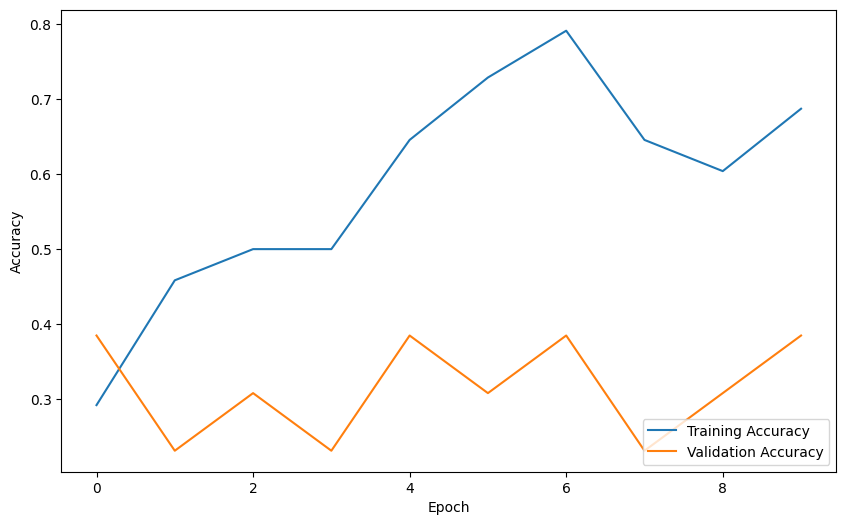

In [10]:
import matplotlib.pyplot as plt

# Plotting training loss vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [11]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

all_predictions = []
all_labels = []

# No gradient computation during evaluation
with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)
        labels = data[1]

        # Convert labels to indices
        numeric_labels = [label_map[label] for label in labels]
        labels_tensor = torch.tensor(numeric_labels, dtype=torch.long).to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels_tensor.cpu().numpy())


# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Class names corresponding to your labels
class_names = ['chalcedony', 'jasper', 'petrifiedwood', 'quartz']

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)



ModuleNotFoundError: No module named 'torch'

#### Breakdown of Results
- __Accuracy__: <br>
So far, the high is 75%, with an average of about 63%. The best parameters seem to be a batch size of 10, epoch of 7, and a learning rate of 0.001
    - updated results (11/18/2024): the new high is 87% after incorporating early-stopping.